In [1]:
# %matplotlib widget

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons

def echelle(freq, ps, Dnu, fmin=None, fmax=None, echelletype="single", offset=0.0):
    '''
    Make an echelle plot used in asteroseismology.
    
    Input parameters
    ----
    freq: 1d array-like, freq
    ps: 1d array-like, power spectrum
    Dnu: float, length of each vertical stack (Dnu in a frequency echelle)
    fmin: float, minimum frequency to be plotted
    fmax: float, maximum frequency to be plotted
    echelletype: str, `single` or `replicated`
    offset: float, an amount by which the diagram is shifted horizontally
    
    Return
    ----
    z: a 2d numpy.array, folded power spectrum
    extent: a list, edges (left, right, bottom, top) 
    
    Users can create an echelle diagram with the following command:
    ----
    
    import matplotlib.pyplot as plt
    z, ext = echelle(freq, power, Dnu, fmin=numax-4*Dnu, fmax=numax+4*Dnu)
    plt.imshow(z, extent=ext, aspect='auto', interpolation='nearest')
    
    '''
    
    if fmin is None: fmin=0.
    if fmax is None: fmax=np.nanmax(x)

    fmin -= offset
    fmax -= offset
    freq -= offset

    fmin = 1e-4 if fmin<Dnu else fmin - (fmin % Dnu)

    # define plotting elements
    resolution = np.median(np.diff(freq))
    # number of vertical stacks
    n_stack = int((fmax-fmin)/Dnu) 
    # number of point per stack
    n_element = int(Dnu/resolution) 

    fstart = fmin - (fmin % Dnu)
    
    z = np.zeros([n_stack, n_element])
    base = np.linspace(0, Dnu, n_element) if echelletype=='single' else np.linspace(0, 2*Dnu, n_element)
    for istack in range(n_stack):
        z[-istack-1,:] = np.interp(fstart+istack*Dnu+base, freq, ps)
    
    extent = (0, Dnu, fstart, fstart+n_stack*Dnu) if echelletype=='single' else (0, 2*Dnu, fstart, fstart+n_stack*Dnu)
    
    x = base
    y = fstart + np.arange(0, n_stack+1, 1)*Dnu + Dnu/2
    
    return z, extent, x, y


def period_echelle(period, ps, DPi, pmin=None, pmax=None, echelletype="single", offset=0.0, backwards=True):
    '''
    Make an echelle plot used in asteroseismology.
    
    Input parameters
    ----
    period: 1d array-like, s
    ps: 1d array-like, power spectrum
    DPi: float, length of each vertical stack (DPi in a period echelle)
    fmin: float, minimum frequency to be plotted
    fmax: float, maximum frequency to be plotted
    echelletype: str, `single` or `replicated`
    offset: float, an amount by which the diagram is shifted horizontally
    backwards: if the period array is descreasing
    
    Return
    ----
    z: a 2d numpy.array, folded power spectrum
    extent: a list, edges (left, right, bottom, top) 
    
    Users can create an echelle diagram with the following command:
    ----
    
    import matplotlib.pyplot as plt
    z, ext = echelle(freq, power, Dnu, fmin=numax-4*Dnu, fmax=numax+4*Dnu)
    plt.imshow(z, extent=ext, aspect='auto', interpolation='nearest')
    
    '''
    
    if backwards: period, ps = period[::-1], ps[::-1]
    
    if pmin is None: pmin=np.nanmin(period)
    if pmax is None: pmax=np.nanmax(period)

    pmin -= offset
    pmax -= offset
    period -= offset

    # pmax = 1e-4 if pmax<1e-4 else pmin - (pmin % period)

    # define plotting elements
    resolution = np.median(np.abs(np.diff(period)))
    # number of vertical stacks
    n_stack = int((pmax-pmin)/DPi) 
    # number of point per stack
    n_element = int(DPi/resolution) 

    pstart = pmax + DPi - (pmax % DPi)
    
    
    z = np.zeros([n_stack, n_element])
    base = np.linspace(-DPi, 0, n_element) if echelletype=='single' else np.linspace(-2*DPi, 0, n_element)
    for istack in range(n_stack):
        z[-istack-1,:] = np.interp(pstart-istack*DPi+base, period, ps)

    extent = (-DPi, 0, pstart, pstart-n_stack*DPi) if echelletype=='single' else (-2*DPi, 0, pstart, pstart-n_stack*DPi)
    
    x = base
    y = pstart - np.arange(0, n_stack+1, 1)*DPi - DPi/2

    return z, extent, x, y



In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# %matplotlib widget

In [4]:
%matplotlib notebook

In [5]:
class Star():
    def __init__(self, nu, ps, numax, Dnu, fmin=None, fmax=None):
        '''
        Make interactive frequency and strectched period echelle plots. Useful for finding Dnu and DPi1.
 
        Input parameters
        ----
        nu: 1d array-like, freq
        ps: 1d array-like, power spectrum
        numax: float, frequency of maximum power
        Dnu: float, p-mode large separation (approximate value is fine)
        fmin: float, minimum frequency to be plotted
        fmax: float, maximum frequency to be plotted
        cmap: str, colormap passed to matplotlib.pyplot.ax.imshow

        Users can create an interactive plot with the following command:
        ----

        %matplotlib widget

        # initiate a star object
        star = Star(nu, ps, numax, Dnu)

        # interactive echelles
        star.plot_freq_echelle()
        
        '''
        # trim data
        fmin = numax-4*Dnu if fmin is None else fmin
        fmax = numax+4*Dnu if fmax is None else fmax
        trim = (nu > fmin) & (nu < fmax)
        self.nu = nu[trim]
        self.ps = ps[trim]
        self.numax = numax
        self.Dnu = Dnu
        
        # initialize slider values
        self.Dnu_init = self.Dnu
        self.eps_p_init = 0.5
        self.d02_init = 0.15
        self.d01_init = 0.
        self.DPi1_init = 250
        self.q_init = 0.5
        
        # get radial orders
        self.ns = np.unique(np.array(self.nu/self.Dnu, dtype=int))[1:-1]

        Theta_p = np.pi * (self.nu/self.Dnu_init- (self.d01_init)) 
        self.tau = 1/(self.nu*1e-6) + self.DPi1_init/np.pi * np.arctan(self.q_init / np.tan(Theta_p))
        
        # passed to echelle api
        self.freq_echelle_kwargs = {'fmin':np.min(self.nu), 'fmax':np.max(self.nu), 'echelletype': 'replicated'}
        self.period_echelle_kwargs = {'pmin':np.min(self.tau), 'pmax':np.max(self.tau), 'echelletype': 'replicated'}
        
#         # passes to matplotlib api
#         self.cmap = cmap
        
#         # flag for snapping to nearest peaks
#         self.snapping = snapping
        
        # Styles for labels                                                                                       
        self.colors = {0: "blue", 1: "red", 2: "orange"}
        self.markers = {0: "o", 1: "^", 2: "s"}
        self.markersize = {0: 35, 1: 40, 2: 35}
        
        
    def plot_freq_echelle(self, snapping=False, cmap='gray_r'):#, plot_l1_line=False):
        ######################################
        ## kwarg initialization
        ######################################
        # passes to matplotlib api
        self.cmap = cmap
        
        # flag for snapping to nearest peaks
        self.snapping = snapping
        
        # flag to add a line in l=0 for the period echelle
#         self.plot_l1_line = plot_l1_line
        
        ######################################
        # callback functions to update on slider interaction
        ######################################
        def update_Dnu(val):
#             self.ax.clear()
            z, ext, self.echelle_x, self.echelle_y = echelle(
                self.nu, 
                self.ps, 
                slider_Dnu.val,
                **self.freq_echelle_kwargs
            )
            
#             image1 = axes[0].imshow(
#             z, 
#             extent=ext, 
#             aspect='auto', 
#             interpolation='nearest', 
#             cmap=self.cmap
#             )
            
            image1.set(array=z, extent=ext)
            axes[0].axis(ext)
            axes[0].set_xlabel(r"Frequency mod {:0.2f} ($\mu$Hz)".format(slider_Dnu.val))
            
            #also need to update the period echelle
#             Theta_p = np.pi * (self.nu/slider_Dnu.val - (slider_d01.val)) 
            #yaguang update:
            Theta_p = np.pi * (self.nu/slider_Dnu.val - (slider_d01.val + 0.5 + slider_eps_p.val))
            self.tau = 1/(self.nu*1e-6) + slider_DPi1.val/np.pi * np.arctan(slider_q.val / np.tan(Theta_p))
            
            z, ext, self.p_echelle_x, self.p_echelle_y = period_echelle(
                self.tau, 
                self.ps, 
                slider_DPi1.val,
                **self.period_echelle_kwargs
            )
            
            image2.set(array=z, extent=ext)
#             image2.set(array=z[::-1,:], extent=ext)
            axes[1].axis(ext)
#             axes[1].invert_yaxis()
            #end update the period echelle

            nu0s = [slider_eps_p.val*self.Dnu_init, (slider_eps_p.val+1)*slider_Dnu.val]
            nu2s = [(slider_eps_p.val-slider_d02.val)*slider_Dnu.val, (slider_eps_p.val-slider_d02.val+1)*slider_Dnu.val, (slider_eps_p.val-slider_d02.val+2)*slider_Dnu.val] 
            for i, nu in enumerate(nu0s): vlines0[i].set_xdata([nu, nu])
            for i, nu in enumerate(nu2s): vlines2[i].set_xdata([nu, nu])
        
            l0 = np.abs(self.nu.reshape(-1,1) - (self.ns+slider_eps_p.val)*slider_Dnu.val ).argmin(axis=0)
            l2 = np.abs(self.nu.reshape(-1,1) - (self.ns+slider_eps_p.val-slider_d02.val)*slider_Dnu.val ).argmin(axis=0)
            for i, tau in enumerate(self.tau[l0]): hlines0[i].set_ydata([tau, tau])
            for i, tau in enumerate(self.tau[l2]): hlines2[i].set_ydata([tau, tau])
            
            fig.canvas.draw_idle()
            update_all_scatters()
            
        def update_eps_p(val):
            nu0s = [slider_eps_p.val*self.Dnu_init, (slider_eps_p.val+1)*slider_Dnu.val]
            nu2s = [(slider_eps_p.val-slider_d02.val)*slider_Dnu.val, (slider_eps_p.val-slider_d02.val+1)*slider_Dnu.val, (slider_eps_p.val-slider_d02.val+2)*slider_Dnu.val] 
            for i, nu in enumerate(nu0s): vlines0[i].set_xdata([nu, nu])
            for i, nu in enumerate(nu2s): vlines2[i].set_xdata([nu, nu])
            
            l0 = np.abs(self.nu.reshape(-1,1) - (self.ns+slider_eps_p.val)*slider_Dnu.val ).argmin(axis=0)
            l2 = np.abs(self.nu.reshape(-1,1) - (self.ns+slider_eps_p.val-slider_d02.val)*slider_Dnu.val ).argmin(axis=0)
            for i, tau in enumerate(self.tau[l0]): hlines0[i].set_ydata([tau, tau])
            for i, tau in enumerate(self.tau[l2]): hlines2[i].set_ydata([tau, tau])
        
            fig.canvas.draw_idle()
            
#             update_all_scatters()
            
        def update_d02(val):
            nu2s = [(slider_eps_p.val-slider_d02.val)*slider_Dnu.val, (slider_eps_p.val-slider_d02.val+1)*slider_Dnu.val, (slider_eps_p.val-slider_d02.val+2)*slider_Dnu.val] 
            for i, nu in enumerate(nu2s): vlines2[i].set_xdata([nu, nu])
            
            l2 = np.abs(self.nu.reshape(-1,1) - (self.ns+slider_eps_p.val-slider_d02.val)*slider_Dnu.val ).argmin(axis=0)
            for i, tau in enumerate(self.tau[l2]): hlines2[i].set_ydata([tau, tau]) 
        
            fig.canvas.draw_idle()
            
#             update_all_scatters()
            
        def update_g(val):
#             Theta_p = np.pi * (self.nu/slider_Dnu.val - (slider_d01.val)) 
            Theta_p = np.pi * (self.nu/slider_Dnu.val - (slider_d01.val + 0.5 + slider_eps_p.val)) 
            self.tau = 1/(self.nu*1e-6) + slider_DPi1.val/np.pi * np.arctan(slider_q.val / np.tan(Theta_p))
            
            z, ext, self.p_echelle_x, self.p_echelle_y = period_echelle(
                self.tau, 
                self.ps, 
                slider_DPi1.val,
                **self.period_echelle_kwargs
            )
            
            image2.set(array=z, extent=ext)
#             image2.set(array=z[::-1,:], extent=ext)
            axes[1].axis(ext)
#             axes[1].invert_yaxis()
            axes[1].set_xlabel('Stretched period mod {:.1f} (s)'.format(slider_DPi1.val))
            fig.canvas.draw_idle()
            
            update_all_scatters()

        
        
        ######################################
        # Initializing the figure 
        ######################################
        fig = plt.figure(figsize=(9.5,6))
        self.fig = fig

        xpos, xoff = 0.16, 0.45
        ypos, yoff = 0.95, 0.04
        width = 0.33
        
        # Dictionary of lists, with index being l-mode label                                                      
        # e.g. label_[1][2] is 3rd frequency for l=1 mode label                                                   
        self.f_labels = {0:[], 1:[], 2:[]}
        
        ######################################
        # Creating Sliders for interactivity (matplotlib widgets)
        ######################################
        # Make a horizontal slider to control Dnu.
        slider_Dnu = Slider(
            ax=fig.add_axes([xpos, ypos, width, 0.03]),
            label='Dnu',
            valmin=self.Dnu*0.9,
            valmax=self.Dnu*1.1,
            valinit=self.Dnu_init,
            valstep=self.Dnu*0.002,
        )
        
        # Make a horizontal slider to control eps_p.
        slider_eps_p = Slider(
            ax=fig.add_axes([xpos, ypos-yoff, width, 0.03]),
            label='eps_p',
            valmin=0.0,
            valmax=1.0,
            valinit=self.eps_p_init,
            valstep=0.01,
        )
        
        # Make a horizontal slider to control d02.
        slider_d02 = Slider(
            ax=fig.add_axes([xpos, ypos-yoff*2, width, 0.03]),
            label='d02',
            valmin=0.0,
            valmax=0.3,
            valinit=self.d02_init,
            valstep=0.005,
        )
        
        # Make a horizontal slider to control d01.
        slider_d01 = Slider(
            ax=fig.add_axes([xpos+xoff, ypos, width, 0.03]),
            label='d01',
            valmin=-0.5,
            valmax=0.5,
            valinit=self.d01_init,
            valstep=0.01,
        )
        
        # Make a horizontal slider to control DPi1.
        slider_DPi1 = Slider(
            ax=fig.add_axes([xpos+xoff, ypos-yoff, width, 0.03]),
            label='DPi1',
            valmin=30,
            valmax=400,
            valinit=self.DPi1_init,
            valstep=0.5,
        )
        
        # Make a horizontal slider to control q.
        slider_q = Slider(
            ax=fig.add_axes([xpos+xoff, ypos-yoff*2, width, 0.03]),
            label='q',
            valmin=0.0,
            valmax=1.0,
            valinit=self.q_init,
            valstep=0.01,
        )
        
        ######################################
        # Creating Radio Buttons for plot labeling (matplotlib widgets)
        ######################################
        axcolor = 'white'
        rax = plt.axes([0.02, 0.4, 0.08, 0.15], facecolor=axcolor) 
#         radio_l = RadioButtons(rax, ('', '$\ell=1$'))#, 'disconnect')) #testing with less options
        radio_l = RadioButtons(rax, ('', '$\ell=0$', '$\ell=1$', '$\ell=2$'))#, 'remove'))
         # this is called in on_key_press and on_click
        

        ######################################
        # Initializing the plot axes 
        ######################################
        # create two axes
        axes = [fig.add_axes([xpos, 0.1, width, 0.7]), fig.add_axes([xpos+xoff, 0.1, width, 0.7]) ]
        self.ax = axes[0]
        self.pax = axes[1]
        
        ######################################
        # fig 1: frequency echelle diagram
        ######################################
        z, ext, self.echelle_x, self.echelle_y = echelle(
                                    self.nu, 
                                    self.ps, 
                                    self.Dnu_init,
                                    **self.freq_echelle_kwargs
                                )
#         self.echelle_x = z[0]
#         self.echelle_y = z[1]
#         print(self.echelle_x,self.echelle_y)

        image1 = axes[0].imshow(
            z, 
            extent=ext, 
            aspect='auto', 
            interpolation='nearest', 
            cmap=self.cmap
        )
        
        axes[0].axis(ext)
        
        nu0s = [self.eps_p_init*self.Dnu_init, (self.eps_p_init+1)*self.Dnu_init]
        nu2s = [(self.eps_p_init-self.d02_init)*self.Dnu_init, (self.eps_p_init-self.d02_init+1)*self.Dnu_init, (self.eps_p_init-self.d02_init+2)*self.Dnu_init] 
        vlines0 = [axes[0].axvline(nu, color='b', linestyle='--', alpha=0.5) for nu in nu0s ]
        vlines2 = [axes[0].axvline(nu, color='g', linestyle='--', alpha=0.5) for nu in nu2s ]
        
        axes[0].set_xlabel(r"Frequency mod {:0.2f} $\mu$Hz".format(self.Dnu_init))
        axes[0].set_ylabel(r"Frequency $\mu$Hz")

        
        ######################################
        # fig 2: streched period echelle diagram
        ######################################
        z, ext, self.p_echelle_x, self.p_echelle_y = period_echelle(
                            self.tau, 
                            self.ps, 
                            self.DPi1_init,
                            **self.period_echelle_kwargs
                        )
#         self.p_echelle_x = z[0]
#         self.p_echelle_y = z[1]

        image2 = axes[1].imshow(
            z, 
            extent=ext, 
            aspect='auto', 
            interpolation='nearest', 
            cmap=self.cmap
        )
#         image2 = axes[1].imshow(
#             z[::-1,:], 
#             extent=ext,
#             aspect='auto', 
#             interpolation='nearest', 
#             cmap=self.cmap
#         )
        
#         print(self.echelle_y)
#         print(self.p_echelle_y)
        
        axes[1].axis(ext)
#         axes[1].invert_yaxis()
        
        l0 = np.abs(self.nu.reshape(-1,1) - (self.ns+self.eps_p_init)*self.Dnu_init ).argmin(axis=0)
        l2 = np.abs(self.nu.reshape(-1,1) - (self.ns+self.eps_p_init-self.d02_init)*self.Dnu_init ).argmin(axis=0)
        hlines0 = [axes[1].axhline(tau, color='b', linestyle='--', alpha=0.5) for tau in self.tau[l0]]
        hlines2 = [axes[1].axhline(tau, color='g', linestyle='--', alpha=0.5) for tau in self.tau[l2]]

        axes[1].set_xlabel('Stretched period mod {:.1f} (s)'.format(self.DPi1_init))
        axes[1].set_ylabel('Stretched period (s)')
        
        
        ######################################
        # initialize a set of scatter points (defaults to nothing)
        #####################################
        self.scatters = [None, None, None]
        self.pscatters = [None, None, None]
        self.scatters1 = [None, None, None]
        self.pscatters1 = [None, None, None]
        self.legend_labels = []
#         self.p_line = [None]
        
        for l in [0,1,2]:
            self.scatters[l] = self.ax.scatter([], [],
                    s=self.markersize[l], marker=self.markers[l], color=self.colors[l], label=f"l={l}")
            self.scatters1[l] = self.ax.scatter([],[],
                    s=self.markersize[l], marker=self.markers[l], color=self.colors[l], label=f"l={l}")
            self.pscatters[l] = self.pax.scatter([], [],
                    s=self.markersize[l]-10, marker=self.markers[l], color=self.colors[l], label=f"l={l}")
            self.pscatters1[l] = self.pax.scatter([],[],
                    s=self.markersize[l]-10, marker=self.markers[l], color=self.colors[l], label=f"l={l}")
            
#         if self.plot_l1_line:
#         print('adding line') ## I still don't know why the line doesn't work!! 
#             self.p_line, = self.pax.plot([],[],
#                                         color='red', linestyle='--', alpha=0.5, zorder=10)
#         self.p_line, = self.pax.plot([13625., 13375., 12625., 12375., 11625., 11625.],
#                                     [-163.44280257,  -64.12580051, -195.92103329, 
#                                      -116.82852551, -17.75166573, -173.79588735],
#                                     color='red', linestyle='--', alpha=0.5)
#         self.pax.plot([13625., 13375., 12625., 12375., 11625., 11625.],
#                                     [-163.44280257,  -64.12580051, -195.92103329, 
#                                      -116.82852551, -17.75166573, -173.79588735],
#                                     color='red', linestyle='--', alpha=0.5, zorder=10)
            
        ######################################
        # initializing the find_peaks to snap to
        ######################################
        # note that this script currently takes a smoothed power spectrum as input
        # so we don't need to smooth the data again for find_peaks
        # additionally we only input a portion of the power spectrum around numax
        # so we don't have to window the region
        
        # adjusting the prominence dynamically is going to the be the issue here
          # you could estimate the noise and then use that as a minimum threshold
        # make a rough background correction to have a flat error estimate for the prominence
        bg_corr = (self.ps*self.nu**2)/np.max(self.nu**2)
        self.peaks, _ = sp.signal.find_peaks(bg_corr,prominence=np.median(bg_corr)*0.75)#prominence=10) 
        self.found_peaks = self.nu[self.peaks]
#         print(self.found_peaks)
        # the found peaks are frequencies, this code below is only if you wish to view those points on the echelle
#         xs = []
#         ys = []
#         for freq in self.found_peaks:
#             x = (freq) % slider_Dnu.val
#             y = freq - x + slider_Dnu.val / 2.
#             xs.append(x)
#             ys.append(y)
#         xs, ys = np.array(xs), np.array(ys)       
#         self.ax.scatter(xs, ys, s=50, marker='x', color='tab:orange')
#         self.ax.scatter(xs + slider_Dnu.val,ys - slider_Dnu.val, s=50, marker='x', color='tab:orange')


        ######################################
        # link sliders to call the update functions
        ######################################
        slider_Dnu.on_changed(update_Dnu)
        slider_eps_p.on_changed(update_eps_p)
        slider_d02.on_changed(update_d02)
        
        slider_d01.on_changed(update_g)
        slider_DPi1.on_changed(update_g)
        slider_q.on_changed(update_g)
        
        
        
        ######################################
        # what to do when you click
        ######################################
        def get_l_mode_choice(choice):
            if choice == '$\ell=0$':
                return 0
            if choice == '$\ell=1$': #restricting to just this one for now
                return 1
            elif choice == '$\ell=2$':
                return 2
            return -1

        
        def update_all_scatters():
            """Update the scatter points to new echelle diagram coordinates"""
            for l in [0,1,2]:
#             for l in list(self.f_labels.keys()):
                update_scatter(l)
        
        def update_scatter(l):
            """Updates scatter plot"""
#             no_label_no_scatter = len(self.f_labels[l]) == 0 and self.scatters[l] == None
#             has_label_no_scatter = len(self.f_labels[l]) != 0 and self.scatters[l] == None

#             if no_label_no_scatter:
#                 return # not sure this is needed

#             # First label of the mode                                                                                 
#             elif has_label_no_scatter:
                # Update scatter plots based on l value                                                               
#             color = self.colors[l]
#             marker = self.markers[l]
            label = f"l={l}"

            # Get frequency coordinates
            xs = []
            ys = []
            for freq in self.f_labels[l]:
                x = (freq) % slider_Dnu.val
                y = freq - x + slider_Dnu.val / 2.
#                 y = self.echelle_y[self.echelle_y < freq].max()# + slider_Dnu.val*5# + self.echelle_y[0]
                xs.append(x)
                ys.append(y)
            xs, ys = np.array(xs), np.array(ys)
            
#             x_labels, y_labels = self.get_coords(self.f_labels[l])
#             self.scatters[l] = self.ax.scatter(xs, ys,
#                 s=50, marker=self.markers[l], color=self.colors[l], label=f"l={l}")
#             self.scatters[l] = self.ax.scatter(xs + slider_Dnu.val, 
#                                                ys - slider_Dnu.val,
#                 s=50, marker=self.markers[l], color=self.colors[l], label=f"l={l}")
#             self.scatters[l] = self.ax.scatter(xs, ys,
#                 s=50, marker=self.markers[l], color=self.colors[l], label=f"l={l}")
#             self.scatters1[l] = self.ax.scatter(xs + slider_Dnu.val, ys - slider_Dnu.val,
#                 s=50, marker=self.markers[l], color=self.colors[l], label=f"l={l}")
            self.scatters[l].set_offsets(np.c_[xs,ys])
            self.scatters1[l].set_offsets(np.c_[xs + slider_Dnu.val,ys - slider_Dnu.val])
        
            pxs = []
            pys = []
            for freq in self.f_labels[l]:
#                 Theta_p = np.pi * (freq/slider_Dnu.val - (slider_d01.val))  
                Theta_p = np.pi * (freq/slider_Dnu.val - (slider_d01.val + 0.5 + slider_eps_p.val))
                tau = 1/(freq*1e-6) + slider_DPi1.val/np.pi * np.arctan(slider_q.val / np.tan(Theta_p))
                
                px = - (slider_DPi1.val - (tau) % slider_DPi1.val)
                py = tau - px - slider_DPi1.val/2
#                 px = (slider_DPi1.val - tau) % slider_DPi1.val
#                 py = self.p_echelle_y[self.p_echelle_y > tau].min()# + slider_Dnu.val*5# + self.echelle_y[0]
                pxs.append(px)
                pys.append(py)
            
            pxs, pys = np.array(pxs), np.array(pys)
                               
            self.sanitycheck1 = pys
            self.sanitycheck2 = pxs
            
#             x_labels, y_labels = self.get_coords(self.f_labels[l])
#             self.pscatters[l] = self.pax.scatter(pxs, pys,
#                 s=50, marker=self.markers[l], color=self.colors[l], label=f"l={l}")
#             self.pscatters[l] = self.pax.scatter(pxs+slider_DPi1.val, 
#                                                pys-slider_DPi1.val,
#                 s=50, marker='o', color='green', label=f"l={l}")
#             self.pscatters[l] = self.pax.scatter(pxs, pys,
#                 s=50, marker=self.markers[l], color=self.colors[l], label=f"l={l}")
#             self.pscatters1[l] = self.pax.scatter(pxs+slider_DPi1.val, pys-slider_DPi1.val,
#                 s=50, marker='o', color='green', label=f"l={l}")
            self.pscatters[l].set_offsets(np.c_[pxs, pys])
            self.pscatters1[l].set_offsets(np.c_[pxs - slider_DPi1.val, pys + slider_DPi1.val])
            
#             if self.plot_l1_line and l == 1:
#                 self.p_line.set_data(np.c_[pxs, pys])
#                 self.pax.relim()
#                 self.pax.autoscale_view(True,True,True)

#             self.pscatters1[l].set_offsets(np.c_[pxs-slider_DPi1.val, pys+slider_DPi1.val])

#                 # Period coordinates                                                                                  
#                 px_labels, py_labels = self.get_pcoords(self.f_labels[l])
#                 self.pscatters[l] = self.pax.scatter(px_labels, py_labels,
#                     s=50, marker=marker, label=label, color=color)

            # Legend labels                                                                                       
            if label not in self.legend_labels:
                self.legend_labels.append(f"l={l}")
#                 self.ax.legend(self.legend_labels) ##THIS DOESN'T WORK YET
#             else: ## not sure if we need this
#                 x_labels, y_labels = self.get_coords(self.f_labels[l])
#                 self.scatters[l].set_offsets(np.c_[x_labels, y_labels])

#                 px_labels, py_labels = self.get_pcoords(self.f_labels[l])
#                 self.pscatters[l].set_offsets(np.c_[px_labels, py_labels])

            # Prevent view from changing after point is added                                                         
            # self.set_extent()                                                                                       
#             self.ax.legend(self.legend_labels)                                                       
#             self.pax.legend(self.legend_labels)

            fig.canvas.draw_idle()

        def onclick(event):
            """Clicking event"""
#             self.cmap = 'BuPu'
            # if you press disconnect it will disconnect you from the interactivity
#             if radio_l.value_selected == 'disconnect':
#                 event.canvas.mpl_disconnect(self.cid)
#                 return

            # Only add label click in the echelle, and selected l mode to label                                       
            click_in_f_plot = event.inaxes == self.ax
            l_mode = radio_l.value_selected
#             print('clicked!')

            #do nothing on the empty radio button
            if not (click_in_f_plot) or l_mode == "":
                return

            # Coordinate of clicks on the image array                                                                 
            clicked_x, clicked_y = event.xdata, event.ydata
#             self.ax.scatter(clicked_x, clicked_y,zorder=10,s=50)
#             fig.canvas.draw_idle()

            # Find the nearest x and y value in self.x and self.y                                                 
            nearest_x_index = (np.abs(self.echelle_x-clicked_x)).argmin()
            # Find y that are just below our cursor                                                               
            nearest_y_index = (np.abs(self.echelle_y-clicked_y)).argmin()
#             self.ax.scatter(self.echelle_x[nearest_x_index], self.echelle_y[nearest_y_index])

            # Point labelling               
            y_inc = (self.echelle_y[0] - self.echelle_y[1])/2
            f = self.echelle_x[nearest_x_index] + (self.echelle_y[nearest_y_index]+y_inc)# + self.echelle_y.min()
            l = get_l_mode_choice(l_mode)
            
            ### Adding a snap to the nearest find_peaks point ###
            # the call to find_peaks is in the main part of the plotter.
            if self.snapping:
                nearest_freq_index = (np.abs(self.found_peaks-f)).argmin()
                f = self.found_peaks[nearest_freq_index]
            
#             self.ax.scatter(self.echelle_x[nearest_x_index], self.echelle_y[nearest_y_index],
#                             s=50, marker=self.markers[l], color=self.colors[l])
#             self.ax.scatter(self.echelle_x[nearest_x_index]+slider_Dnu.val, 
#                             self.echelle_y[nearest_y_index]-slider_Dnu.val,
#                             s=50, marker=self.markers[l], color=self.colors[l])
#             fig.canvas.draw_idle()
            self.f_labels[l].append(f) # add this point to the dictionary of frequencies
            self.f_labels[l].sort()
            update_scatter(l)
        

        
        ######################################
        # add point upon mouse click
        ######################################
#         self.labels = 0
#         self.legend_labels = []

#         # 3 scatter plots corresponding to l-mode labels                                                          
# #         self.create_label_scatters()
        cid = self.fig.canvas.mpl_connect('button_press_event', onclick) #this creates the scatter points 
                                                                #and also updates the scatter plot        
        plt.show()

Court log:
fixed the redraw issue so no more floating points.

If we change to a plot instead of a scatter then we'll need to add in a part to sort the frequencies after we append them to the list of frequencies.

I still have no idea what's going on in the period echelle. I fixed the x-tau thing so now we "should" be plotting from the right hand side but that didn't actually seem to really change anything so I'm a bit confused about that. I think once we have a new period echelle function that everything will make a bit more sense (praying?) -- for now I am going to revert to the one that actually makes sense to me.

Need to fix the jumping between vertical orders when I slide, I think this may have to do with self.echelle_y not being called properly? I don't know how that would be the case but it seems that it is. - this happens when they pass either the middle or half of Dnu, so I think it's an issue with the definition of y in the echelle plotter

There's also an issue with the bottom two rows of the plots where I click and the points don't actually snap to the right locations. This issue also occurs on the right half of the echelle. Okay actually its on the two left hand sides of the duplicated echelle, and it always jumps down. i wonder if this is related to the jumping when I slide delta nu to certain places - I think it's related to the call to y. I don't think the plotter is doing it correctly.

Mild cleanup - the two update scatters are doing exactly the same things so i am going to combine them for clarity's sake

In [6]:
def read_star(star_name,suppress_output=True,unpack=False,newvals=True):
#     delta_nu,nu_max,mass,lc,ps
    if newvals == False:
        delta_nu = highmass_rc['Delnu'][highmass_rc['KIC']==float(star_name[4:])].values[0]
        nu_max = highmass_rc['numax'][highmass_rc['KIC']==float(star_name[4:])].values[0]
    else:
        delta_nu = highmass_rc_newvals['Delnu'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
        nu_max = highmass_rc_newvals['numax'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
#         mass = highmass_rc_newvals['ClcorM'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
    mass = highmass_rc['ClcorM'][highmass_rc['KIC']==float(star_name[4:])].values[0]
    if suppress_output == False:
        print(star_name)
        if newvals == False:
            print('Using Jie values')
        else:
            print('Using new values')
        print('delta_nu =',delta_nu)
        print('nu_max =',nu_max)
        print('mass =',mass)
    
    lightcurve = pd.read_csv('KIC'+star_name[4:]+'_LC.csv')
    powerspec = pd.read_csv('KIC'+star_name[4:]+'_PS.csv')
    if unpack == True:
        if suppress_output == False:
            print('unpacking data frames')
        time = np.asarray(lightcurve['time'])
        flux = np.asarray(lightcurve['flux'])
        freq = np.asarray(powerspec['freq'])
        power = np.asarray(powerspec['power'])
        amp = np.asarray(powerspec['amp'])
        return delta_nu,nu_max,mass,time,flux,freq,power,amp
    else:
        if suppress_output == False:
            print('returning dataframes')
        return delta_nu,nu_max,mass,lightcurve,powerspec

In [7]:
import pandas as pd 
highmass_rc = pd.read_csv('highmass_rc_werr.csv')
highmass_rc_newvals = pd.read_csv('highmass_rc_newvals.csv')
adjusted_masses = pd.read_csv('adjusted_masses.csv')

In [8]:
delta_nu,nu_max,mass,lightcurve,powerspec = read_star('KIC 3758458',suppress_output=False)
delta_nu,nu_max,mass,time,flux,freq,power,amp = read_star('KIC 3758458',unpack=True,suppress_output=False)

KIC 3758458
Using new values
delta_nu = 5.836
nu_max = 74.21
mass = 3.7
returning dataframes
KIC 3758458
Using new values
delta_nu = 5.836
nu_max = 74.21
mass = 3.7
unpacking data frames


In [9]:
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
smooth_percent = 0.02
freq_res = np.median(np.diff(freq))
smoothed_power = convolve(power, Box1DKernel((delta_nu*smooth_percent)/freq_res))

In [10]:
# # plt.axhline(np.median(ps)/np.asarray(nu**2),color='k')
# bg_corr = (ps*nu**2)/np.max(nu**2)

# fig = plt.figure(figsize=(10,5))
# plt.plot(nu, ps)
# plt.plot(nu,(ps*nu**2)/np.max(nu**2))
# plt.axhline(np.median((ps*nu**2)/np.max(nu**2))*0.75,color='k')
# # plt.axhline(np.median(ps),color='k')
# # plt.scatter(star.found_peaks,ps[star.peaks],color='tab:green')
# plt.scatter(star.found_peaks,bg_corr[star.peaks],color='tab:green')
# plt.show()

In [11]:
# star.found_peaks

In [12]:
# star.sanitycheck1

In [13]:
# star.sanitycheck2

<IPython.core.display.Javascript object>


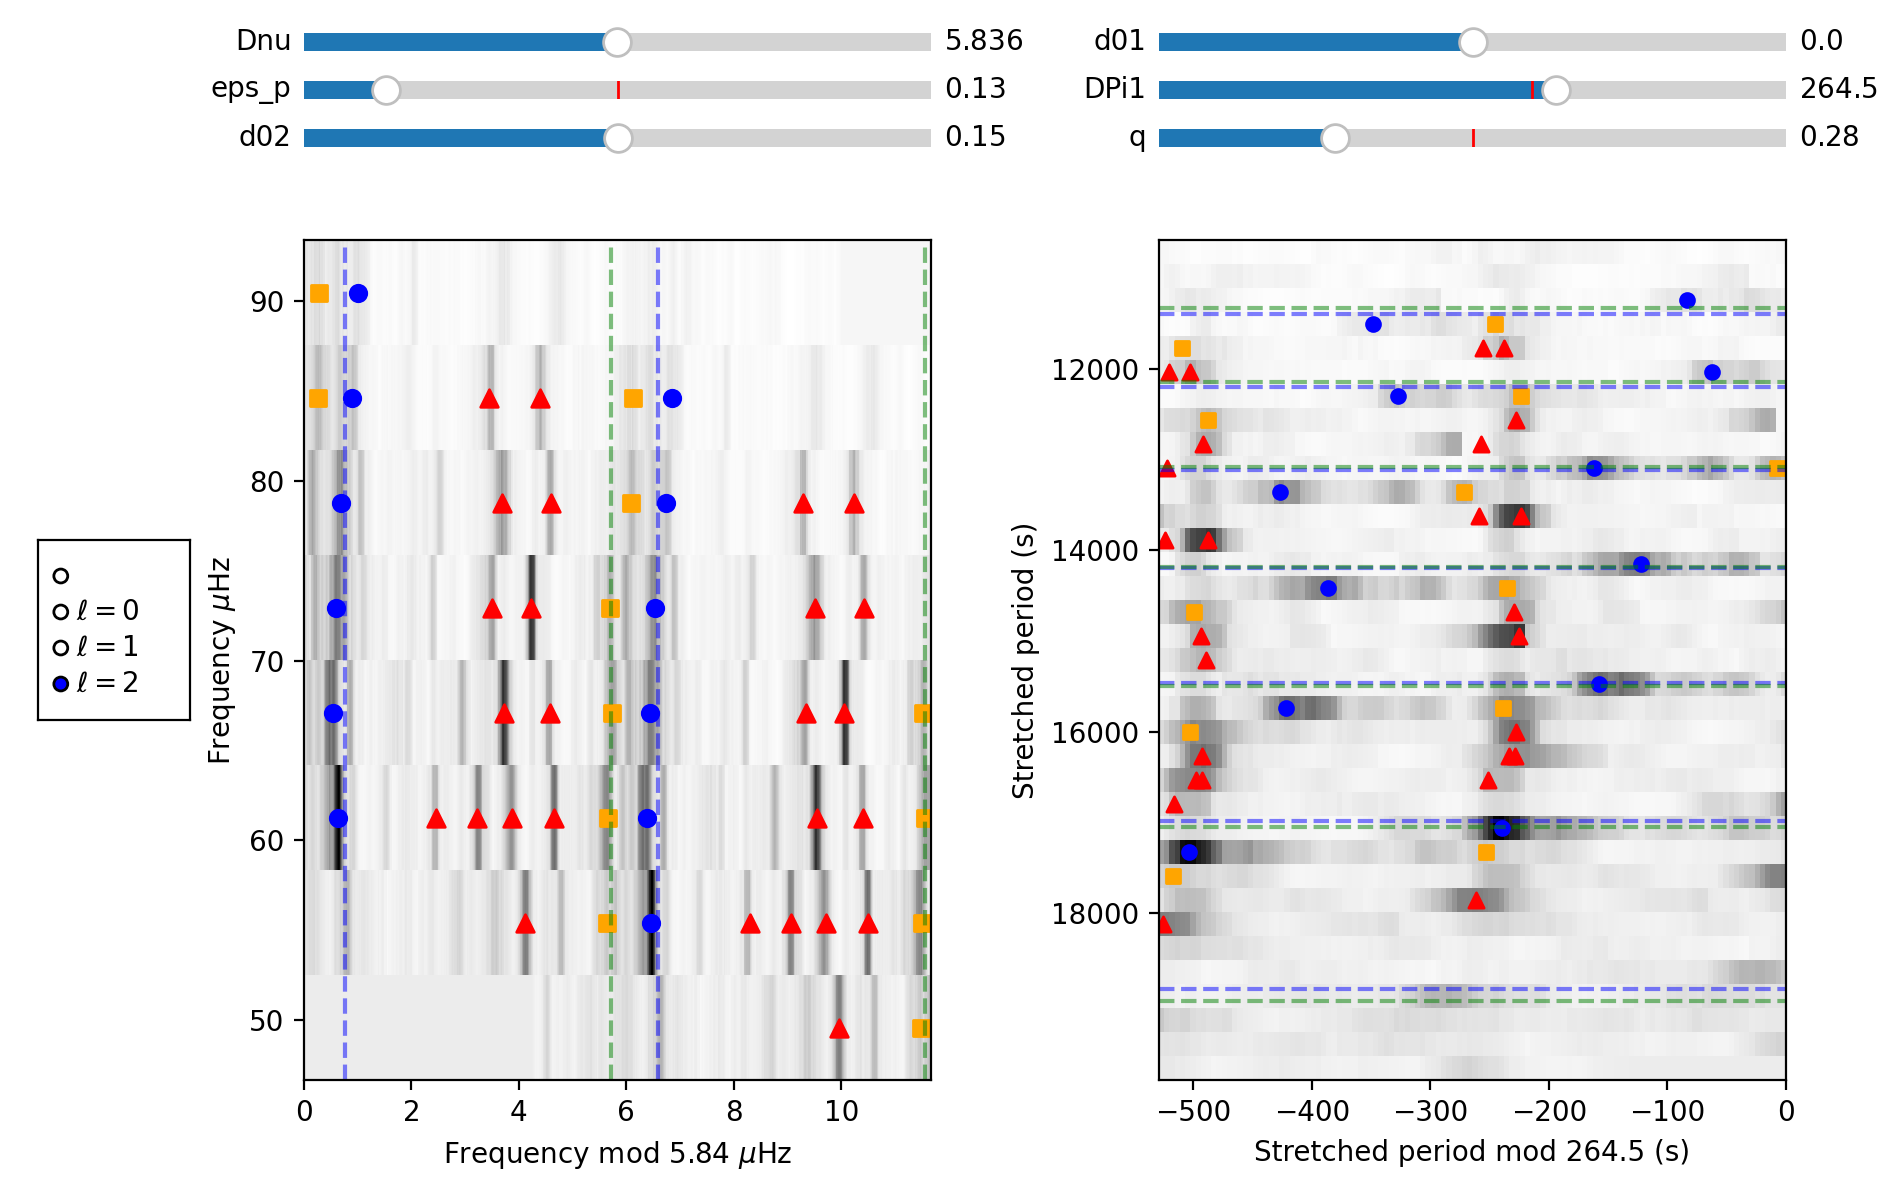

In [14]:
# resample spectrum to have 5000 pixels
nu = np.linspace(nu_max-4*delta_nu, nu_max+4*delta_nu, 5000)
ps = np.interp(nu, freq, smoothed_power)

# initiate a star object
star = Star(nu, ps, nu_max, delta_nu)

# interactive echelles
star.plot_freq_echelle(snapping=True)#,plot_l1_line=True)
# plt.show()

In [15]:
# star.sanitycheck

In [16]:
star.f_labels

{0: [], 1: [], 2: []}

In [17]:
from scipy.optimize import curve_fit
from scipy.optimize import minimize,basinhopping

In [18]:
def lorentzian(x, amplitude, center, width):
    return (amplitude*width**2/((x-center)**2+width**2))

def peakbag(l,freq_list,freq,power,dnu):
    #want to fit a lorentzian to the region around the clicked peak
    for f in freq_list:
        # probably want to mask around the peak itself
        power_region = power[(f-(dnu*0.07) < freq) & (freq < f+(dnu*0.07))]
        freq_region = freq[(f-(dnu*0.07) < freq) & (freq < f+(dnu*0.07))]
        
        popt, pcov = curve_fit(lorentzian, freq_region, power_region,
                               p0=[max(power_region), f, 0.1])#,
#                               bounds=([0, 0, 0.05], np.inf))
        perr = np.sqrt(np.diag(pcov))
    
        def minus_log_likelihood(theta, freq, power):
            amp, cen, wid, bg = theta
            model = lorentzian(freq,amp,cen,wid) + bg
            return np.sum(np.log(model) + power/model)
        bnds = ((0, None), None, None, None)
#         res = minimize(minus_log_likelihood, [max(power_region), f, 0.1, 1], 
#                        args=(freq_region,power_region), bounds=bnds)
        kwargs = dict({'args':(freq_region,power_region),'method':'BFGS','bounds':bnds})
        res = basinhopping(minus_log_likelihood, [max(power_region), f, 0.1, 1], 
                       minimizer_kwargs=kwargs) # note that BFGS doesn't take bounds so this will have to change
        err = np.sqrt(np.diag(res.lowest_optimization_result.hess_inv))
    
        print('------- CURVE FIT VALUES --------')
        print('Amplitude:',np.round(popt[0],2),'+/-',np.round(perr[0],2))
        print('Center:',np.round(popt[1],2),'+/-',np.round(perr[1],2))
        print('Width:',np.round(popt[2],4),'+/-',np.round(perr[2],4))
        
        print('------- MINIMIZE VALUES ---------')
        print('Amplitude:',np.round(res.x[0],2),'+/-',np.round(err[0],2))
        print('Center:',np.round(res.x[1],2),'+/-',np.round(err[1],2))
        print('Width:',np.round(res.x[2],4),'+/-',np.round(err[2],4))
        print('BG:',np.round(res.x[3],1),'+/-',np.round(err[3],2))
        
#         print(res.lowest_optimization_result.hess_inv)
        
        fig = plt.figure(figsize=(4,2))
        plt.plot(freq_region,power_region,label='data')
        plt.plot(freq_region,lorentzian(freq_region,*popt),
                 linestyle='--',label='curve fit')
        plt.plot(freq_region,lorentzian(freq_region,*res.x[:-1]),
                 linestyle='--',label='minimize fit')
        plt.legend()
        plt.xlabel(r'Frequency ($\mu$Hz)')
        plt.ylabel('Power')
        plt.show()
        
def estimate_dpi(freq_list,numax,dnu):
    # a very back of the envelope estimate
#     freq_list = np.sort(freq_list)
    df = np.diff(freq_list)
    # only take the frequencies next to each other
    df = df[df < dnu*0.5]
    dpi = df/(numax**2) * 1e6
    print('All Dpis:',dpi)
    print('Average Dpi:',np.average(dpi))

In [19]:
estimate_dpi(star.f_labels[1],star.numax,star.Dnu)

All Dpis: []
Average Dpi: nan


In [20]:
peakbag(1,star.f_labels[1],freq,power,star.Dnu)

In [21]:
# fig = plt.figure(figsize=(10,5))
# plt.plot(freq,power)
# plt.xlim(nu_max*0.5,nu_max*1.5)
# plt.xlim(80,90)
# subset = power[(nu_max*0.8 < freq) & (freq < nu_max*1.2)]
# plt.ylim(0,max(subset)*1.2)
# plt.xlabel(r'Wavelength ($\mu$Hz)')
# plt.ylabel('Power')
# plt.show()